# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [31]:
import os
import cv2
from PIL import Image
import optuna
from optuna.trial import TrialState
import atom.data_cleaning as dc
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = '../data/images'
pixels_per_side = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset loading and preprocessing

In [32]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
labels = np.array(labels)
classes = ['Danaus plexippus', 'Heliconius charitonius', 'Heliconius erato', 'Junonia coenia', 'Lycaena phlaeas',
           'Nymphalis antiopa', 'Papilio cresphontes', 'Pieris rapae', 'Vanessa atalanta', 'Vanessa cardui']

In [5]:
print([classes[labels[i]] for i in range(10)])

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data, mode='RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx])
        return data, labels

In [33]:
trans = transforms.Compose([
    transforms.ToTensor()
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
sum_of_squared_diff = torch.zeros(3)
for images, _ in dataloader:
    sum_of_squared_diff += ((images - mean.unsqueeze(1).unsqueeze(2))**2).sum(dim=[0, 2, 3])
std = torch.sqrt(sum_of_squared_diff / total_count)
mean = [mean[0].item(), mean[1].item(), mean[2].item()]
std = [std[0].item(), std[1].item(), std[2].item()]

In [8]:
print(mean, std)

[0.4616279900074005, 0.4468429684638977, 0.3207762539386749] [0.2861473262310028, 0.2681962549686432, 0.27681371569633484]


Display some samples

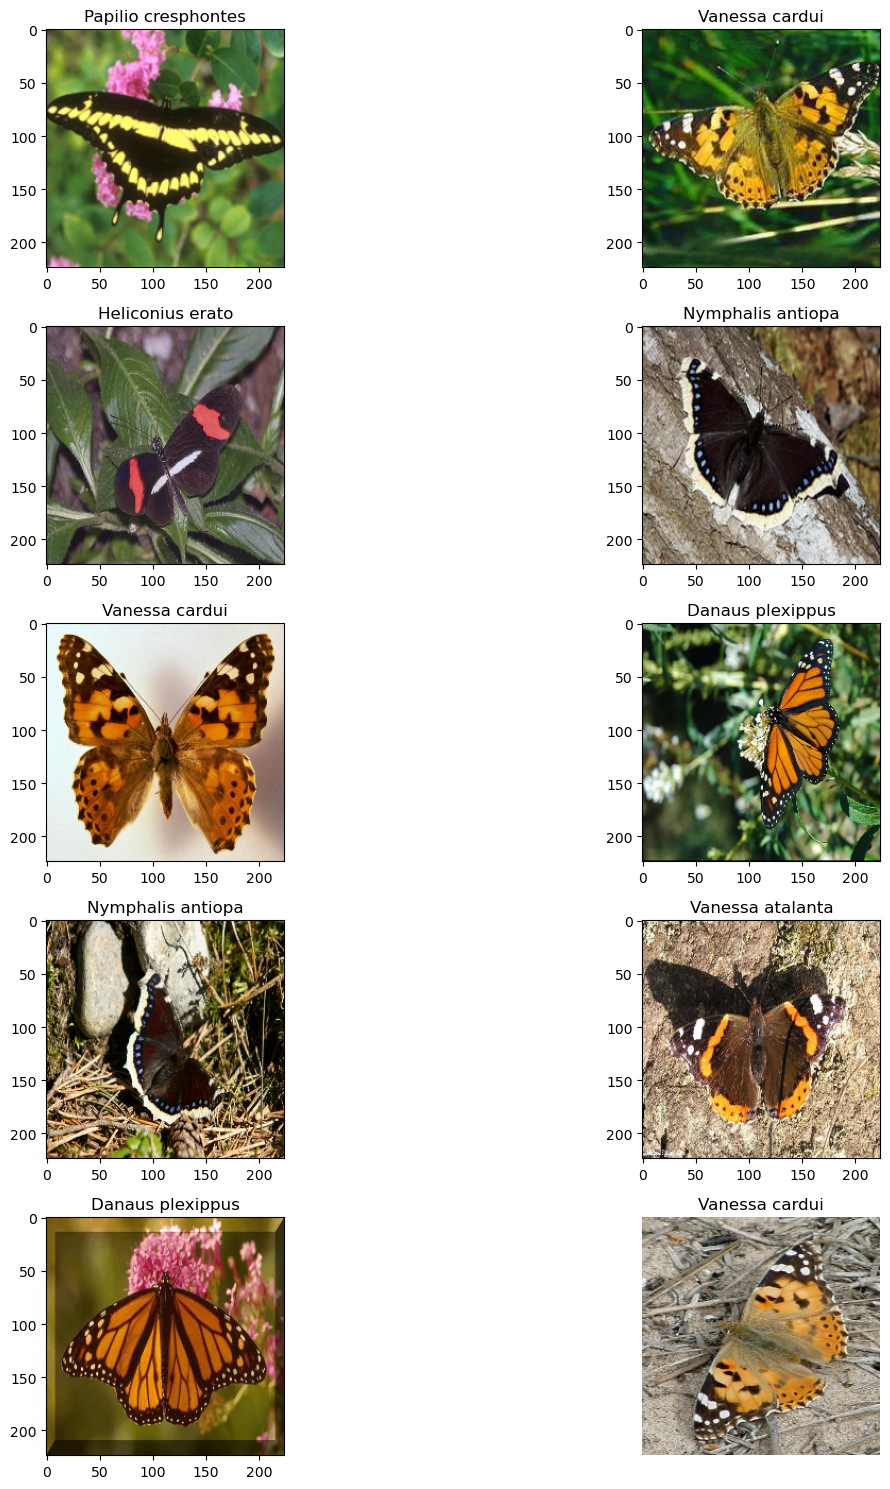

In [9]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(classes[labels[l]]))
plt.axis('off')        
plt.tight_layout()

Display dataset distribution

In [10]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(classes)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

TypeError: 'list' object is not callable

### Data cleaning

Scaling the Feature Set: standardize your dataset to ensure all features are on a similar scale.

In [34]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
data = []
for img, _ in dataloader:
    data.append(img.numpy())
data = np.concatenate(data, axis=0)
data = data.reshape(len(data), -1)

Use this to check dataset shape

In [12]:
print(data.shape, labels.shape)
print(data)
print(labels)

(832, 150528) (832,)
[[-0.8457886  -0.7635603  -0.6676272  ... -0.6629778  -0.7338119
  -0.80464596]
 [-0.42094228 -0.9965404  -0.969131   ... -0.35130787 -0.32297426
  -0.33714107]
 [-0.68133193 -0.6402178  -0.6539225  ...  0.6120355   0.5978687
   0.5978687 ]
 ...
 [-0.8457886  -0.87319803 -0.87319803 ... -1.0879823  -1.0738155
  -1.1304827 ]
 [-0.5168753  -0.5168753  -0.5716942  ...  0.07369658 -0.0113043
  -0.0113043 ]
 [ 0.68913996  0.67543525  0.6617305  ... -0.11047199 -0.0113043
   0.00286252]]
[4 9 9 3 4 5 6 0 7 5 1 9 8 6 1 9 3 7 1 9 3 0 3 5 8 5 9 9 7 4 9 5 0 6 6 5 8
 6 4 6 8 3 4 9 6 3 3 9 6 7 2 3 5 8 0 1 0 7 3 7 3 0 2 4 6 4 5 1 6 8 6 8 3 6
 8 4 1 1 9 5 9 0 4 1 1 6 6 4 3 6 9 0 0 2 0 8 5 4 2 9 0 5 6 3 8 0 3 1 5 9 3
 5 0 1 5 9 7 1 7 9 8 2 8 6 5 9 5 3 1 5 5 3 9 9 9 2 7 1 8 8 2 2 2 8 1 9 5 6
 3 8 6 5 1 0 3 5 5 2 1 8 6 4 8 7 3 8 5 0 4 4 6 6 4 9 1 1 8 8 3 0 0 1 0 6 8
 0 3 5 4 0 9 4 1 6 7 1 6 0 9 2 6 5 5 6 3 0 4 9 8 4 8 5 0 3 4 0 5 2 9 0 3 9
 3 0 0 5 4 5 9 7 8 2 3 2 4 0 6 5 4 7 9 8 0

Handling Outliers: detect and manage outliers in your dataset.

In [35]:
data, labels = (dc.Pruner(strategy=['lof', 'iforest'],
                          device='cpu',
                          engine='sklearn',
                          verbose=2,
                          iforest={'contamination': 'auto', 'bootstrap': True, 'n_jobs': -1, 'random_state': 1},
                          lof={'n_neighbors': 20, 'contamination': 'auto', 'n_jobs': -1}
                          )
                .fit_transform(data, labels))

Fitting Pruner...
Pruning outliers...
 --> The LocalOutlierFactor detected 12 outliers.
 --> The IsolationForest detected 276 outliers.
 --> Dropping 12 outliers.


In [36]:
data = data.values.reshape(-1, pixels_per_side, pixels_per_side, 3)
labels = labels.values

## Training pipeline

Split into training data and test data

In [37]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
trainset, testset = random_split(dataset, [0.85, 0.15])
testloader = DataLoader(testset, batch_size=64, shuffle=False)

CNN definition

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120 * 49 * 49, 64) # ((224 -4)/2 -4)/2 -4
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 220, 220]          456
├─MaxPool2d: 1-2                         [1, 6, 110, 110]          --
├─Conv2d: 1-3                            [1, 16, 106, 106]         2,416
├─MaxPool2d: 1-4                         [1, 16, 53, 53]           --
├─Conv2d: 1-5                            [1, 120, 49, 49]          48,120
├─Flatten: 1-6                           [1, 288120]               --
├─Linear: 1-7                            [1, 64]                   18,439,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 18,491,386
Trainable params: 18,491,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 183.19
Input size (MB): 0.60
Forward/backward pass size (MB): 6.07
Params size (MB): 73.97
Estimated Total Size (MB): 80.63

Train and validate methods

In [38]:
def fit(net, trainloader, optimizer, loss_fn=nn.CrossEntropyLoss()):
    net.train()
    total_loss = acc = count = 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

def predict(net, valloader, loss_fn):
    net.eval()
    count = acc = total_loss = 0
    with torch.no_grad():
        for features, labels in valloader:
            features = features.to(device)
            labels = labels.to(device)
            count += len(labels)
            out = net(features)
            total_loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum()
    return total_loss.item() / count, acc.item() / count

Objective method for k fold cross validation

In [52]:
def objective(trial, net, trainset, X, y):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    epochs = trial.suggest_int('epochs', 10, 25)
    optimizer = getattr(optim, trial.suggest_categorical('optimizer', ['SGD', 'Adam']))(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"\ntrial #{trial.number} => lr={lr}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}")
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    val_accs = []
    split_num = 0
    for train_index, val_index in skf.split(X, y):
        split_num += 1
        train_data = Subset(trainset, train_index)
        val_data = Subset(trainset, val_index)
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train_loss, train_acc = fit(net, trainloader, optimizer, criterion)
            val_loss, val_acc = predict(net, valloader, criterion)
            
        print(f"Split {split_num}, Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.3f},"
              f"Val loss={val_loss:.3f}")
        val_accs.append(val_acc)
        mean_acc = np.mean(val_accs)
        trial.report(mean_acc, split_num)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_acc

In [53]:
X = np.zeros(len(trainset))
labelloader =  DataLoader(trainset, batch_size=128, shuffle=False)
y = []
for _, label in labelloader:
    y.append(label.numpy())
y = np.concatenate(y, axis=0)
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, net, trainset, X, y), n_trials=6)


trial #0 => lr=3.029530125790621e-05, batch_size=128, epochs=15, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 3.029530125790621e-05
    maximize: False
    weight_decay: 0
)
Split 1, Train acc=0.443, Val acc=0.143, Train loss=0.015,Val loss=0.033
Split 2, Train acc=0.711, Val acc=0.529, Train loss=0.012,Val loss=0.025
Split 3, Train acc=0.853, Val acc=0.814, Train loss=0.009,Val loss=0.019
Split 4, Train acc=0.936, Val acc=0.871, Train loss=0.007,Val loss=0.015
Split 5, Train acc=0.973, Val acc=0.986, Train loss=0.005,Val loss=0.010
Split 6, Train acc=0.987, Val acc=0.986, Train loss=0.004,Val loss=0.007
Split 7, Train acc=0.992, Val acc=1.000, Train loss=0.003,Val loss=0.005
Split 8, Train acc=1.000, Val acc=1.000, Train loss=0.002,Val loss=0.004
Split 9, Train acc=1.000, Val acc=0.986, Train loss=0.002,Val loss=0.003
Split 10, Train acc=1.000, Val

In [54]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  6
  Number of pruned trials:  0
  Number of complete trials:  6
Best trial:
  Value:  1.0
  Params: 
    lr: 0.0018662862413342
    batch_size: 64
    epochs: 25
    optimizer: SGD
